# LROSE Wind Tutorial

---

This interactive tutorial takes you through the steps of how to run [FRACTL](http://wiki.lrose.net/index.php/FRACTL) and [SAMURAI](http://wiki.lrose.net/index.php/SAMURAI). FRACTL is a fast traditional solver with integrated interpolation using LROSE infrastructure, and it is able to perform both gridding and multi-Doppler synthesis for airborne radars and multiple ground-based radars. This is different than Radx2Grid which is only capable of gridding data for a single ground-based radar. FRACTL adopts techniques from older REORDER and CEDRIC software, but with some new improvements. In contrast to the older tools, in which interpolation is followed by synthesis, FRACTL does both steps together. FRACTL doesn’t require the CfRadial file with an aggregation of the sweeps, which is different than Radx2Grid. FRACTL performs a nearest neighbor interpolation of the reflectivity instead of bilinear interpolation in Radx2Grid. It combines the Doppler velocities together using the traditional 'normal' equations but with singular value decomposition of raw velocities in spherical space rather than Cramer's rule in gridded space like CEDRIC. 

SAMURAI is a variational analysis technique that is described in [Bell et al. (2012)](https://doi.org/10.1175/JAS-D-11-0276.1), [Foerster et al. (2014)](https://doi.org/10.1175/MWR-D-13-00313.1), [Foerster and Bell (2017)](https://doi.org/10.1175/JTECH-D-17-0073.1), [Cha and Bell (2021)](https://doi.org/10.5194/amt-14-3523-2021), [Cha and Bell (2023)](https://github.com/csu-tropical/csu-tropical/blob/master/Publications/papers/Cha_Bell_JTECH_2023.pdf), and other publications. The SAMURAI analysis yields a maximum likelihood estimate of the atmospheric state for a given set of observations and error estimates by minimizing a variational cost function. SAMMURAI employs a finite element approach using a series of overlapping cubic B-spline basis functions. 
This approach offers several advantages over a conventional grid-point representation, including:

- Allowing for a scaled-controlled analysis that can incorporate multiple spatial filters in the background error covariance and analytic spatial derivatives in observational space.
- No need to interpolate irregular data distributions to a Cartesian grid, and the data can be used in the variational minimization in their native locations.
- Spatial derivative constraints are considered as pseudo-observations, which can be implicitely integrated during the cost function minimmization at any point in their native coordinate.

It has more features and more development than FRACTL, and is generally recommended over the former for publication-quality analysis. The two programs together provide a powerful combination to produce high quality multi-Doppler wind fields from ground-based, airborne, or mixed configurations.

<div>
<img src="../images/samurai.png" width="700"/>
</div>

---


## Tutorial Overview

### 1. Setup 

#### Directory organization 

<div>
<img src="../images/LROSE_wind_structure_2.png" width="800"/>
</div>

#### Required input data, FRACTL and SAMURAI parameter files, and a SAMURAI center file:

**a. QC-ed radar data files will be used in this example:**
* cfrad.20080411_182140.206_to_20080411_182632.190_KHTX_SUR.nc
* cfrad.20080411_182230.747_to_20080411_182629.530_ARMOR_SUR.nc

*The QC process is not included in this tutorial. 

**b. Parameter files:**
* fractl_params
* samurai_params

*Note: The parameter file have already been modified to run straight out of the box.*

**c. Center file:**

*Note: The .cen file was generated by the provided Perl script.* The center file is used in SAMURAI to define a static or moving Cartesian frame of reference for the analysis. It can be used to time-space correct the position of radar data in a moving storm system. It also sets the temporal limits for data to be included in the analysis. 
* Generate_center.pl
* 20080411.cen

#### Environment and packages¶

First, we import the required python packages to run this notebook. Most of the LROSE processing can be done with the os package and shell commands. 

In [1]:
import os
#### Need to modify later
os.environ['BASE_DIR'] = os.getcwd()
os.environ['LROSE_DIR'] = '/usr/local/lrose/bin'
base_dir = os.environ['BASE_DIR']
!echo "Base directory: "$BASE_DIR
!echo "LROSE Directory: "$LROSE_DIR

Base directory: /bell-scratch/tcha/LROSE/AMSRadar2023/tycha/ams-open-radar-2023/notebooks/lrose
LROSE Directory: /usr/local/lrose/bin


The required data is under the **data** directory, and the parameter files used for the tutorial are under the **params** directory. We will organize the directory by performing the following commands:

In [7]:
# create samurai output directory
!rm -rf ${BASE_DIR}/output_sam
!mkdir ${BASE_DIR}/output_sam

# create samurai output directory
!rm -rf ${BASE_DIR}/output_frac
!mkdir ${BASE_DIR}/output_frac

### 2. Prepare data for analysis

In this tutorial, the provided data have already been QC-ed. For a standard procedure, users are recommended to perform the following procedure:

* Convert radar data from level 2 or other native format to CfRadial using RadxConvert 
    - SAMURAI can also incorporate non-radar data, and can read many commonly used formats. All data files in the <code lang="bash">data</code> directory will be included in the analysis. The read subroutine for each datatype is determined by the file suffix.

* Quality-controlled raw data by desired QC-tools. See the QC tutorial for an example of how QC can be done; HawkEdit and Solo can also be used to QC data.

### 3. Set the FRACTL parameters

* If starting from scratch, generate a parameter file using
<code lang="bash">fractl -print_params > fractl_params</code>

* Modify the parameter file
    - Most of the defaults are fine for many analyses. The following are the minimum ones you need to set:
---
* **GRID SPEC**
    * zGrid [line 190], yGrid [line 200], xGrid [line 210]: These determine the grid increment and size of the domain. With FRACTL, you can just set the increment and let the program figure out the domain size if you prefer. In that use case, it picks a rectangular domain that incorporates all the radar data provided.
* **PROJECTION**
    * projLat0 [line 255], projLon0 [line 265]: The origin is an arbitrarily chosen point, but should be relevant for your objective. For example, it can be the geographical center of your multi-radar domain, the physical location of a radar for a single-radar domain, or the location of a feature of interest within your dataset (such as storm center). The latitude and longitude of your chosen origin should be given in decimal degrees.
* **FILES AND DIRECTORIES**
    * inDir [line 453]: This is the input data directory
    * fileRegex [line 463]: This is a regular expression used to filter out the data types used for analysis. It should generally be ^cfrad, to find files that start with cfrad prefix.
    * outNc [line 496]: This is the output directory where the analysis will go.
* **FIELDS**
    * radialName [line 512]: Variable name for the Doppler velocity
    * dbzName [line 522]: Variable name for the reflectivity
    * ncpName [line 532]: Variable name for the normalized coherent power. This variable can be used to do some simple QC thresholding. If you don't have NCP or SQI in your data then just point this to any other variable and make sure the thresholding is turned off (which is the default). The specification of NCP will be optional in future versions of FRACTL.

### 4. Run FRACTL

After modifying the parameter file, directing to the parameter file by typing the *-params* flags

In [6]:
!${LROSE_DIR}/fractl -params ${BASE_DIR}/params/fractl_params 

/bin/bash: fractl: command not found


### 5. Plot FRACTL results

#### Environment and packages
Import the packages to plot the FRACTL output. These are pre-installed for this tutorial, but if you run this notebook on your own computer you may need to install them yourself using the following code (where scipy is a representative example):

<code lang="bash">import sys</code>

<code lang="bash">!{sys.executable} -m pip install scipy</code> 

or 

<code lang="bash">!{sys.executable} -m conda install scipy</code>

depending on your system

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import xarray as xr
import matplotlib as mpl
import cartopy.crs as ccrs
from metpy.plots import ctables
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
mpl.rcParams['figure.dpi'] = 300


Load the FRACTL netcdf file

In [8]:
inDir = base_dir+"/output_frac/20080411/"
file = "ncf_20080411_182632.nc"
ds_radar = xr.open_dataset(inDir+file).squeeze()
ds_radar.load()

<xarray.Dataset>
Dimensions:          (z0: 30, y0: 171, x0: 191)
Coordinates:
    time             datetime64[ns] 2008-04-11T18:26:32.190000128
  * z0               (z0) float64 0.0 500.0 1e+03 ... 1.35e+04 1.4e+04 1.45e+04
  * y0               (y0) float64 -7e+04 -6.9e+04 -6.8e+04 ... 9.9e+04 1e+05
  * x0               (x0) float64 -1.2e+05 -1.19e+05 -1.18e+05 ... 6.9e+04 7e+04
Data variables: (12/14)
    grid_mapping_0   int32 0
    lat0             (y0, x0) float64 34.01 34.01 34.01 ... 35.55 35.55 35.55
    lon0             (y0, x0) float64 -88.07 -88.06 -88.05 ... -86.01 -86.0
    start_time       float64 1.208e+09
    stop_time        float64 1.208e+09
    W                (z0, y0, x0) float32 nan nan nan nan ... nan nan nan nan
    ...               ...
    DBZ              (z0, y0, x0) float32 nan nan nan nan ... nan nan nan nan
    NCP              (z0, y0, x0) float32 nan nan nan nan ... nan nan nan nan
    conditionNumber  (z0, y0, x0) float32 nan nan nan nan ... nan nan nan nan
    W_std            (z0, y0, x0) float32 nan nan nan nan ... nan nan nan nan
    V_std            (z0, y0, x0) float32 nan nan nan nan ... nan nan nan nan
    U_std            (z0, y0, x0) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.5

In [9]:
## Get variables:
da_DBZ = ds_radar['DBZ']
da_U = ds_radar['U']
da_V = ds_radar['V']
da_W = ds_radar['W']

# we will also grab the condition number for later
da_CN = ds_radar['conditionNumber']


First, we will plot the reflectivity and winds retrieved by FRACTL at 3-km altitude. To produce a clean figure, the wind every fourth grid point is plotted.

Text(0.5, -0.1, '[dBZ]')

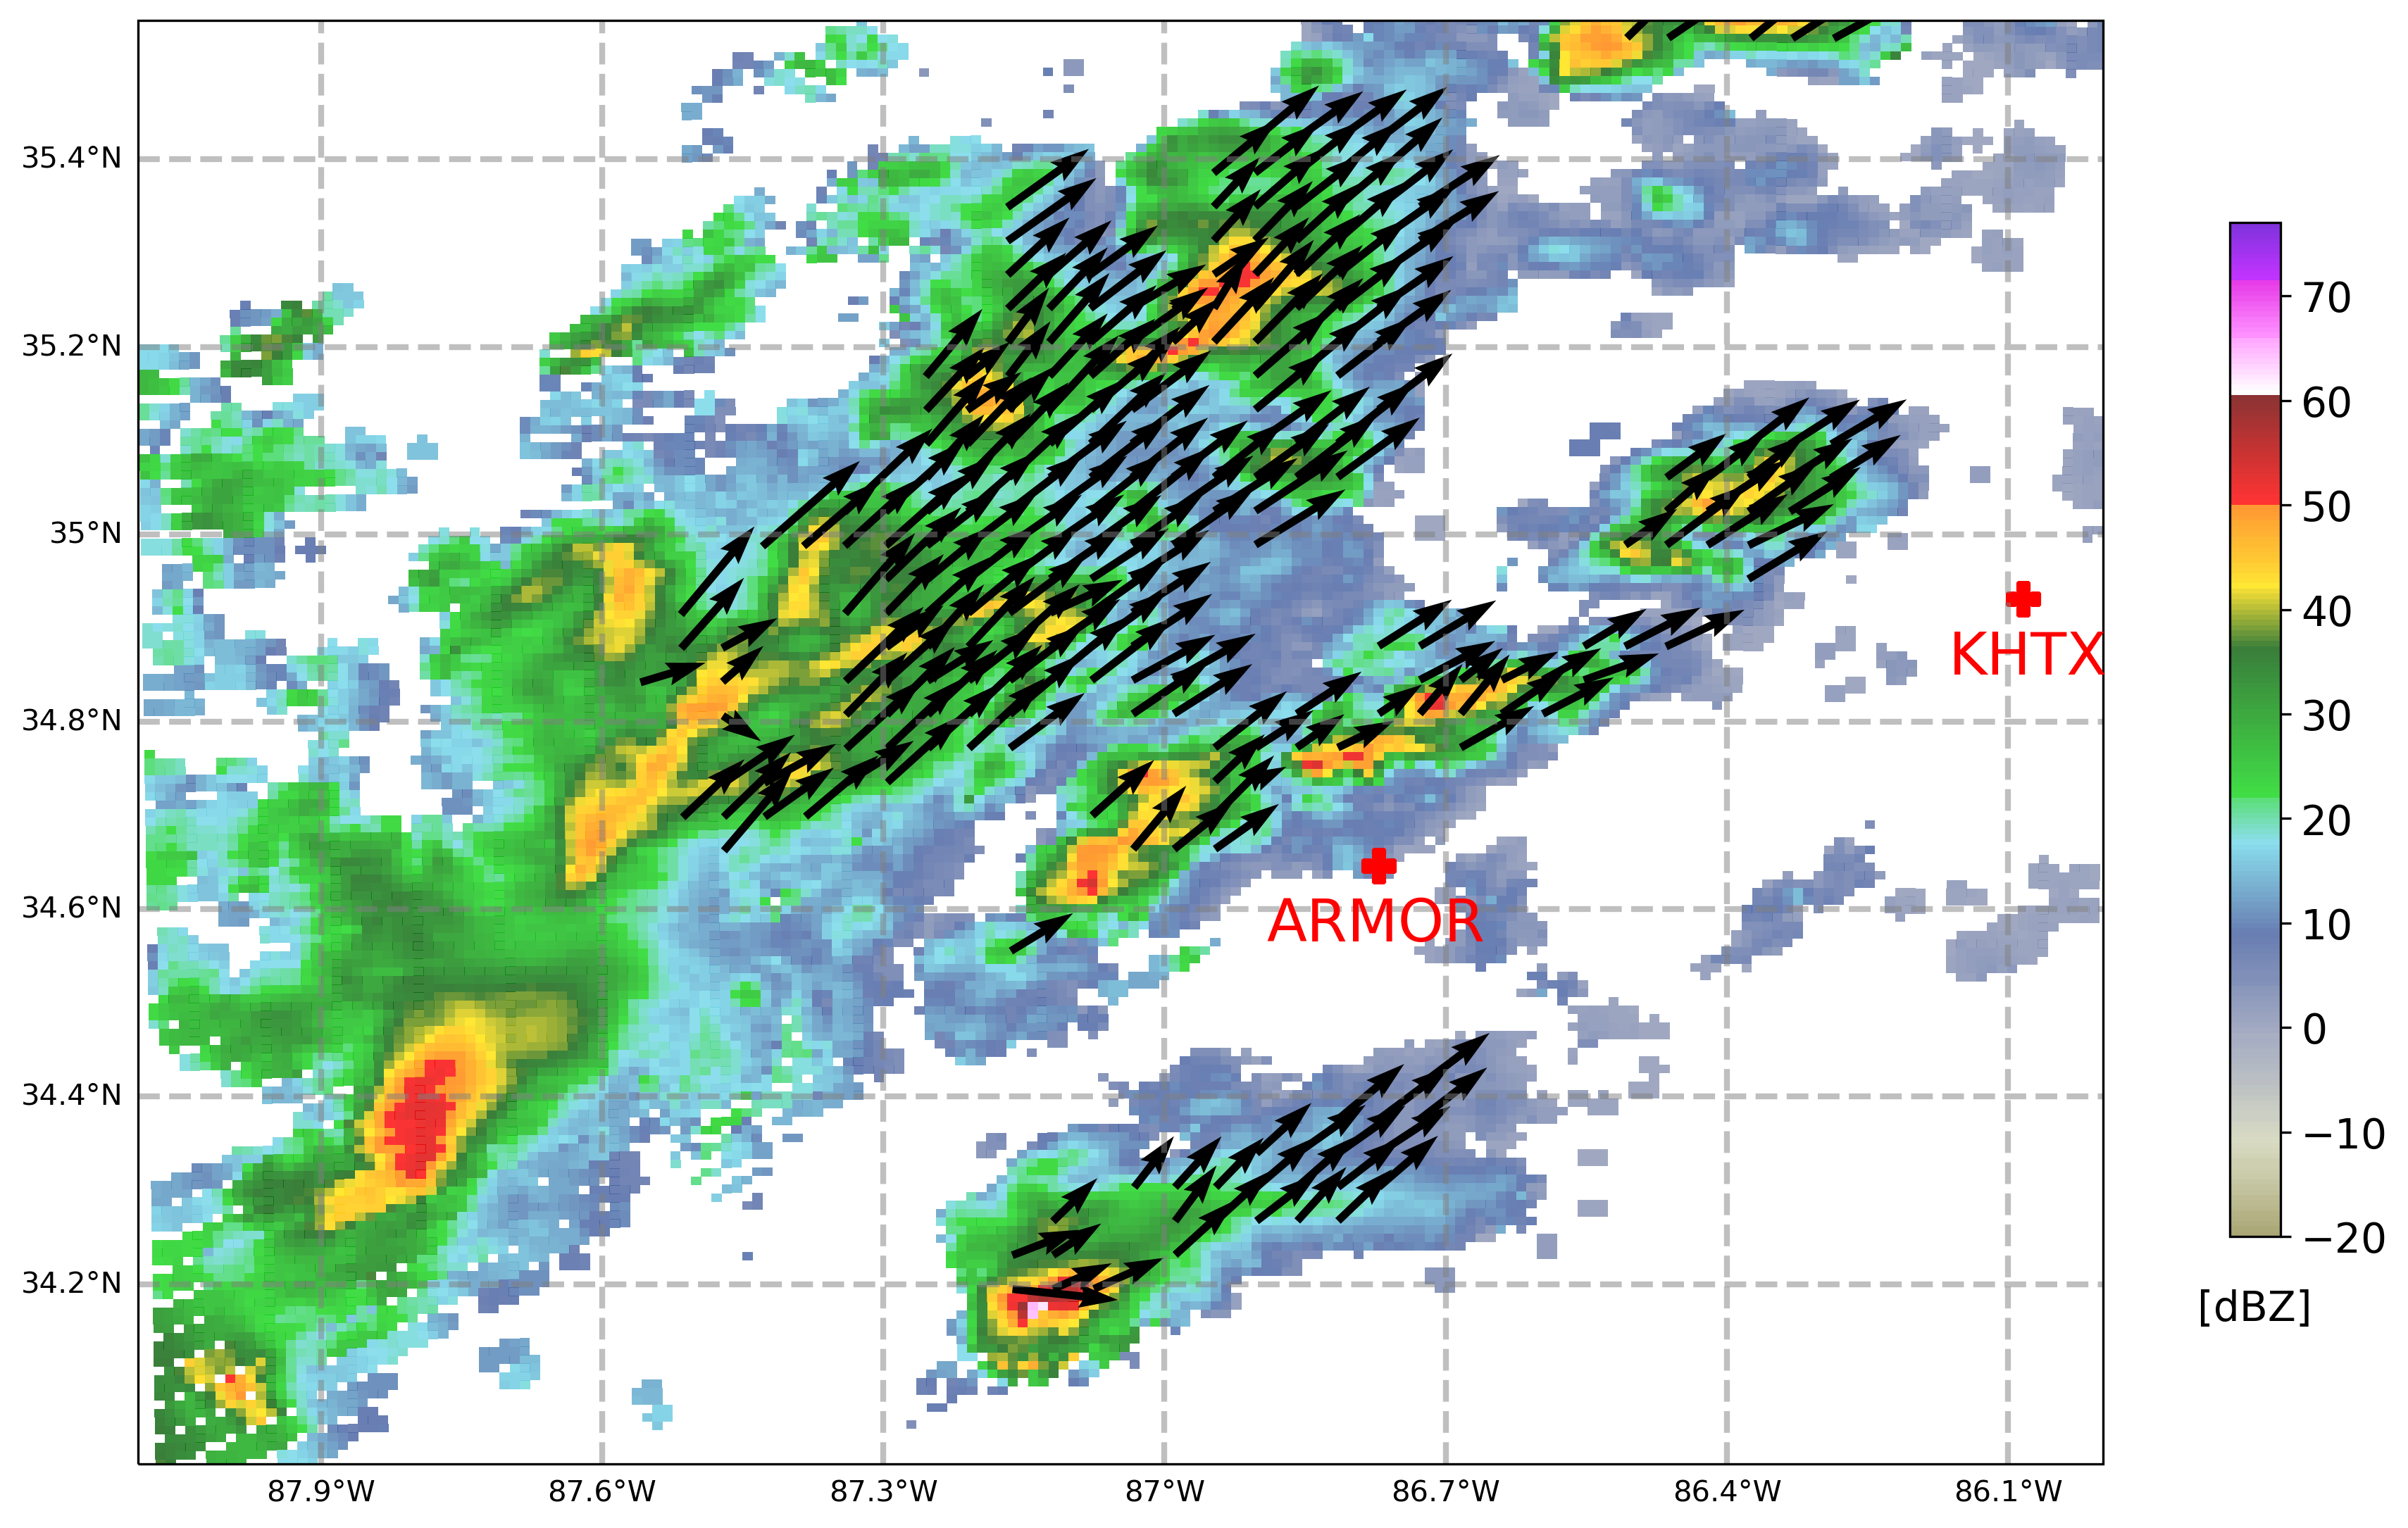

In [10]:
## Set NWS reflectivity colorbar:
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', -20, 0.5)
plotting_alt_f=3*1000 # altitude at 3 km, fractl outputs altitude in m
plotting_var = da_DBZ.sel(z0=plotting_alt_f).data
plotting_var_u = da_U.sel(z0=plotting_alt_f).data
plotting_var_v = da_V.sel(z0=plotting_alt_f).data
plotting_lon = ds_radar.lon0
plotting_lat = ds_radar.lat0

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
    
ext = 0#0.02    
ax.set_extent([np.min(plotting_lon)+ext, np.max(plotting_lon)-ext, np.min(plotting_lat)+ext, np.max(plotting_lat)-ext], crs=ccrs.PlateCarree())
    
cf1 = ax.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=ref_cmap, norm=ref_norm
                    , alpha=0.8
                    , shading='auto'
                    , transform=ccrs.PlateCarree() 
                    )
step = 4
cf_q = ax.quiver( plotting_lon[::step, ::step], plotting_lat[::step, ::step]
                    , plotting_var_u[::step, ::step], plotting_var_v[::step, ::step]
                    , scale=600
                    , width=0.004
                    , color='k'
                    , transform=ccrs.PlateCarree() 
                    )

# radar locations (ARMOR, KHTX)
radar_lats = [34.6462, 34.9306]
radar_lons = [-86.7715, -86.0836]
ax.scatter(radar_lons, radar_lats, c='r', marker='P', s=120, transform=ccrs.PlateCarree())
ax.text(radar_lons[0]-0.12, radar_lats[0]-0.08, 'ARMOR', color='r', transform=ccrs.PlateCarree(), fontsize=20)
ax.text(radar_lons[1]-0.08, radar_lats[1]-0.08, 'KHTX', color='r', transform=ccrs.PlateCarree(), fontsize=20)


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[dBZ]', fontsize=14, y=-0.1)


### If you can see the above plot, then congratulations! You have successfully created and plotted a dual-Doppler analysis. Now let's try SAMURAI

### 6. Set the SAMURAI parameters

* One difference between FRACTL and SAMURAI is the requirement of a centerfile, which allows for a moving domain. Modify and run the Generate_center.pl perl script to generate a time-series of center locations by providing an estimation of the moving speed of the target and the reference location. The .cen file can be generated by typing the following command into a terminal:
<code lang="bash">./Generate_center.pl</code>

* Modify the parameter file

Like FRACTL, most of the defaults are fine for general usage. Here are the minimum parameters that need to be set:
---
* **OPERATION SECTION**
    * data_directory [line 197] : This is where your input data is located
    * output_directory [line 209] : This is where your analysis output will go
* **GRID DEFINITION SECTION**
    * i_min [line 302]: I refers to the first horizontal dimension. Usually this is a Cartesian 'x' dimension. For cylindrical analyses (RTZ mode), this is radius. The 'i_min' sets the minimum value (i.e. left side) in km.
    * i_max [line 310]: This sets the maximum i value (right side).
    * i_incr [line 318]: This sets the i (usually x) grid increment in km.
    * j_min [line 326]: J refers to the second horizontal dimension. Usually this is a Cartesian 'y' dimension. For cylindrical analyses (RTZ mode), this is azimuth. The 'j_min' sets the minimum value (i.e. lower) in km.
    * j_max [line 334]: This sets the maximum j value (upper).
    * j_incr [line 342]: This sets the j (usually y) grid increment in km.
    * k_min [line 350]: K refers to the vertical dimension, which is always 'z' dimension. The 'k_min' sets the minimum value (i.e. bottom) in km. It should usually be zero.
    * k_max [line 358]: This sets the maximum k value (top).
    * k_incr [line 366]: This sets the k (always z) grid increment in km.
* **BACKGROUND SECTION**
    * ref_time [line 392]: This is the reference time to which all data will be time-space corrected. It must be a valid time in the centerfile or an error will occur.
* **RADAR SECTION**
    * radar_skip [line 426]: This option can be used to skip beams in the radar data. When set to '1', all beams are used. Setting it to 2 speeds up the calculation and is useful for preliminary analysis. It should generally be set to 1 for final analysis.
    * radar_stride [line 434]: This option sets the number of gates over which averaging occurs along the beam. A stride of '1' uses all data, and higher numbers average multiple gates of the given stride. Higher numbers speed up the calculation and can be used to thin the data to achieve desired spatial resolution of the input velocities.
    * radar_dbz [line 464]: The name of the reflectivity field in the radar data.
    * radar_vel [line 476]: The name of the Doppler velocity field in the radar data.
    * radar_sw [line 484]: The name of the spectrum width field in the radar data. This value is used to set the observational error for the Doppler velocity. If you don't have spectrum width, you can point it at another variable (like NCP) or create a simple uniform field. This will be made optional in the next SAMURAI release.
    * i_reflectivity_roi [line 492], j_reflectivity_roi [line 500], k_reflectivity_roi [line 508]: These variables set the radius of influence for the reflectivity interpolation. They should be similar to the grid increments defined above.
    * mask_reflectivity [line 524]: The analysis can be set to missing data where there is no reflectivity. If set to 'None' then no masking is performed. A numerical value will be used as a threshold for the masking, with all data at nodes having less than the given reflectivity value removed. If you are not using a background field then it is generally a good idea to set this to some small number (like -10 dBZ) since the winds are not valid if there is no radar data. Alternatively, you can use the FRACTL to threshold out that data using a geometric constraint.

The following are optional parameters:
---
* **BACKGROUND SECTION**
    * load_background [line 107]
        * TRUE: A first guess of the analysis stored in the <code lang="bash">samurai_Background.in</code> will be loaded. This can come from a model, sounding, or other data source if available. Most of the time it is not available so it should be set to FALSE.
        * FALSE (default setting)
    * adjust_background [line 132]
        * TRUE: the background will be adjusted to satisfy the mass continuity and match the supplied data using a variational adjustment. Without this, it is just interpolated simply to the grid. 
* **OPERATION SECTION**
    * mode [line 170]: The default mode is MODE_XYZ, which is Cartesian grid. You can run in cylindrical mode with MODE_RTZ. Stay tuned for more radar centric RTZ mode in the near future!
    * preprocess_obs [line 219]
        * TRUE: the raw data files will be preprocessed according to their file suffixes, and a <code lang="bash">samurai_Observations.in</code> file will be generated.
        * FALSE: SAMURAI will load the observations from the <code lang="bash">samurai_Observations.in</code> file located in the data_directory. This is useful for generating fake data, or for saving some time if you already ran the preprocessing of lots of files.
    * num_iterations [line 232]: SAMURAI has the ability to take the output analysis and use it as a first guess for another analysis. This can be useful to create a 'coarse' analysis, followed by a 'fine' analysis. It is very important to set the observation and background errors appropriately if you choose this option.
* **BACKGROUND SECTION**
    * ref_state [line 380]: a sounding file to define the hydrostatic reference state used in the analysis. The default is the Dunion (2011) moist tropical sounding file. The analysis is generally not sensitive to this sounding, as it is just used to provide a reference density field and fall speed relationships in most cases. If you are analyzing thermodynamic information or have a very different freezing level it may be useful to provide a more appropriate sounding. The file format is similar to that of WRF or CM1 idealized soundings.
    * i_background_roi [line 402], j_background_roi [line 412]: These set the background radius of influence when loading a background field.
* **RADAR SECTION**
    * qr_variable [line 452]: In the default 'dbz' mode, the reflectivity is just interpolated and not included in the cost function minimization. If this is set to 'qr', then reflectivity is converted to liquid water using Z-M relationships defined in Gamache et al. (1993) and used as an additional variable in the cost function minimization. This is useful if you have other liquid water measurements to assimilate. Since this is a relatively simple Z-M it should be used with caution. 
    * dbz_pseudow_weight [line 516]: SAMURAI has the ability to set a 'soft' w=0 boundary condition at echo top, and setting this weight will determine how soft or hard that constraint is enforced. Usually a hard w=0 is enforced via the spline boundary conditions at the bottom and top of the domain, so this is optional. It can be useful if the vertical velocities are believed to be too strong at the top of the cloud.
    * melting_zone_width [line 532], mixed_phase_dbz [line 540], rain_dbz [line 548]: SAMURAI has some basic terminal fall speed corrections that use reflectivity and Z-VT relationships. These parameters control which relationships are used depending on dbz and the height of the zero C level (which is determined from the reference sounding).
* **BOUNDARY CONDITIONS SECTION**

Available options are R0, R1T0, R1T1, R1T2, R2T10, R2T20, R3, and PERIODIC following Ooyama (2002). The default "non"- boundary condition (R0) adds a buffer set of gridpoints that are used to calculate the solution but are discarded for output. Different boundary conditions can be set on the left (L) or right (R) side of the domain for each variable and dimension. The most common option other than R0 would be R1T0 for vertical velocity (rhow = 0) at the surface and/or domain top. Periodic domains are only valid for the i and j dimension, but are available in both the XYZ and RTZ mode. Improved boundary conditions are currently in development.
* **OBSERVATION ERRORS SECTION**

Specified error is given in terms of a standard deviation, and is fixed for all observations from a particular instrument except radar. In the radar case, the spectrum width and elevation angle (proportional to terminal fall speed contribution) are used to define the error for each radar gate. A minimum error (radar_min_error) is also enforced.
* **ITERATION DEPENDENT SECTION**
    * mc_weight [line 1450]: specify the weight given to the mass continuity constraint. Default is set to 1, and is generally not recommended to change unless you have a good reason.
    * i_filter_length [line 1546], j_filter_length [line 1558], k_filter_length [line 1570]
     - Gaussian recursive filter is a low-pass filter. Smaller filter lengths retain more detail, and larger filter lengths smooth more. The general recommendation is 4, 4, 2, which removes features less than approximately 4dx, 4dy, and 2dz from the analysis.
    * i_spline_cutoff [line 1582], j_spline_cutoff [line 1594], k_spline_cutoff [line 1606]
     - Spline cutoff is implemented as a third derivative constraint on the cubic B-spline basis during the spline transform. It is a sharper filter than the Gaussian, roughly equivalent to a sixth order filter.
    * i_max_wavenumber [line 1618], j_max_wavenumber [line 1630], k_max_wavenumber [line 1642]
     - The Fourier spectral filter is the sharpest filter. It can be used for desired effects, such as explicitly removing high-wavenumber features in the spectral domain (usually for RTZ analysis), or for producing a 'mean' field by restricting to wavenumber zero.
     
     
**More details about different parameter setting can be found in the** [SAMURAI Users Manual](https://github.com/mmbell/samurai/blob/master/doc/SAMURAI-User-Manual.pdf)

### 7. Run SAMURAI

After modifying the parameter file, directing to the parameter file by typing the *-params* flags

In [6]:
!samurai -params ${BASE_DIR}/params/samurai_params 


Initializing SAMURAI 3D
iMin	iMax	iIncr	jMin	jMax	jIncr	kMin	kMax	kIncr
-120	70	1	-70	100	1	0	14.5	0.5

Can't open Reference State file for reading,  'dunion_mt.snd' using default...
Debug: num files = 4
DEBUG: center date = 2008-04-11 00:00:00.000000, time = 0
Found matching reference time 18:21:01 at 34.6461983, -86.7714996
Physical (mish) State size = 57329664
Nodal State size = 7479136
Grid dimensions: (191, 171, 30)
Found zero C level at 4153.56983 based on reference sounding
Debug: num files = 4
Found 4 data files to read...
Processing 20080411.cen of type cen
Processing cfrad.20080411_182140.206_to_20080411_182632.190_KHTX_SUR.nc of type cfrad
Observation problem: 0, Time problem: 0, Coordinate problem: 0, Domain problem: 78377, Radius problem: 0
obVector size: 141629
Processed 141629 observations from 228432 entries (10.333418%) file: cfrad.20080411_182140.206_to_20080411_182632.190_KHTX_SUR.nc
141629 total observations. ( 2 of 4 files processed ) 
Processing cfrad.20080411_182

### 8. Plot SAMURAI results

#### Environment and packages¶
The packages were already imported when we plotted the FRACTL results.


#### Load the SAMURAI netcdf file

In [11]:
inDir_s = base_dir+"/output_sam/"
file_s = "samurai_XYZ_analysis.nc"
ds_radar_s = xr.open_dataset(inDir_s+file_s).squeeze()
ds_radar_s.load()


<xarray.Dataset>
Dimensions:     (longitude: 191, latitude: 171, altitude: 30)
Coordinates:
  * longitude   (longitude) float32 -88.08 -88.07 -88.06 ... -86.02 -86.01
  * latitude    (latitude) float32 34.01 34.02 34.03 34.04 ... 35.53 35.54 35.55
  * altitude    (altitude) float32 0.0 0.5 1.0 1.5 2.0 ... 13.0 13.5 14.0 14.5
    time        datetime64[ns] 2008-04-11T18:21:01
Data variables: (12/53)
    x           (longitude) float32 -120.0 -119.0 -118.0 ... 68.0 69.0 70.0
    y           (latitude) float32 -70.0 -69.0 -68.0 -67.0 ... 98.0 99.0 100.0
    U           (altitude, latitude, longitude) float32 nan nan nan ... nan nan
    V           (altitude, latitude, longitude) float32 nan nan nan ... nan nan
    W           (altitude, latitude, longitude) float32 nan nan nan ... nan nan
    WSPD        (altitude, latitude, longitude) float32 nan nan nan ... nan nan
    ...          ...
    DQVDZ       (altitude, latitude, longitude) float32 nan nan nan ... nan nan
    DPDZ        (altitude, latitude, longitude) float32 nan nan nan ... nan nan
    DRHODX      (altitude, latitude, longitude) float32 nan nan nan ... nan nan
    DRHODY      (altitude, latitude, longitude) float32 nan nan nan ... nan nan
    DRHODZ      (altitude, latitude, longitude) float32 nan nan nan ... nan nan
    MCRESIDUAL  (altitude, latitude, longitude) float32 -0.256 0.0714 ... 0.2398

In [12]:
## Get variables:
da_s_DBZ = ds_radar_s['DBZ']
da_s_U = ds_radar_s['U']
da_s_V = ds_radar_s['V']
da_s_ABSVORT = ds_radar_s['ABSVORT']
da_s_DIV = ds_radar_s['DIV']

First we will plot the reflectivity and the retrieved wind from the SAMURAI analysis at 3-km altitude, just like we did for FRACTL. To produce a clean figure, the wind is plotted every 6 grid points. Notice how the data coverage compares to FRACTL.

Text(0.5, -0.1, '[dBZ]')

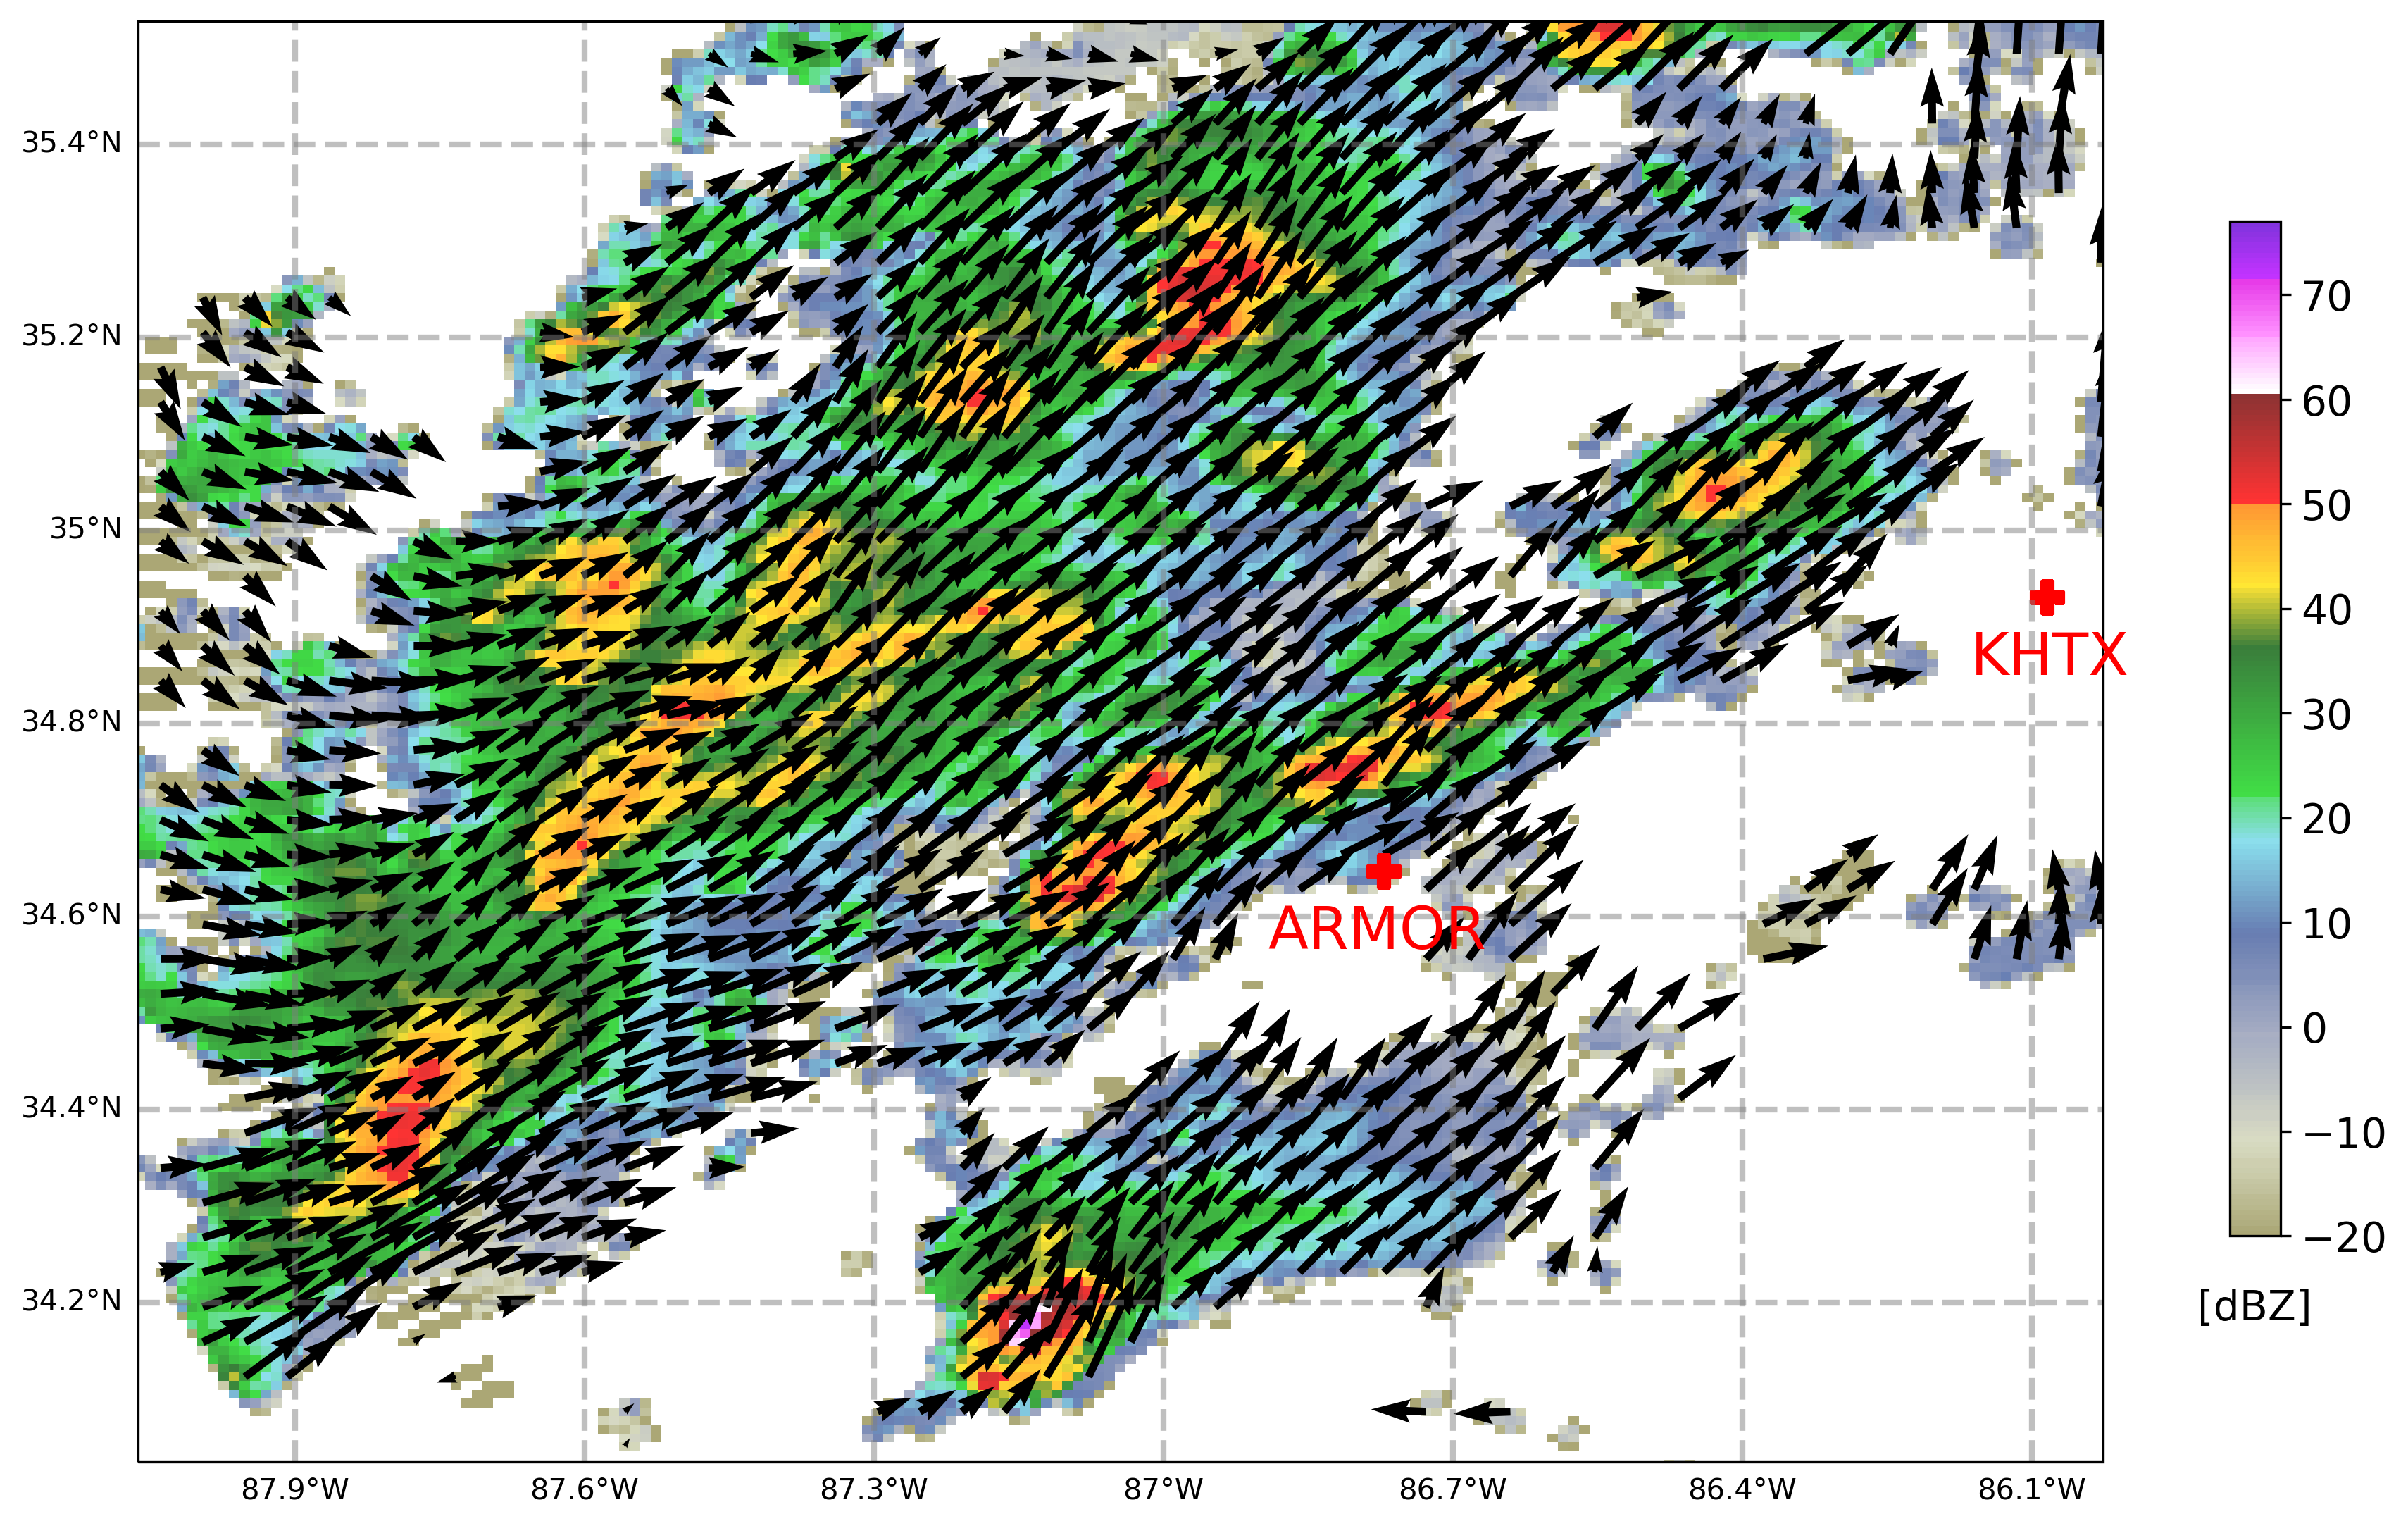

In [13]:
## Set NWS reflectivity colorbar:
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', -20, 0.5)
plotting_alt_s=3 # altitude at 3 km, samurai outputs altitudes in km
plotting_var_s = da_s_DBZ.sel(altitude=plotting_alt_s)
plotting_var_u_s = da_s_U.sel(altitude=plotting_alt_s).data
plotting_var_v_s = da_s_V.sel(altitude=plotting_alt_s).data
plotting_lon_s = ds_radar_s.longitude
plotting_lat_s = ds_radar_s.latitude

fig = plt.figure(figsize=(12,12),facecolor='white')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m', linewidth=1.)
    
ext = 0.02    
ax.set_extent([np.min(plotting_lon_s)+ext, np.max(plotting_lon_s)-ext, np.min(plotting_lat_s)+ext, np.max(plotting_lat_s)-ext], crs=ccrs.PlateCarree())
    
cf1 = ax.pcolormesh( plotting_lon_s, plotting_lat_s, plotting_var_s
                    , cmap=ref_cmap, norm=ref_norm
                    , alpha=0.8
                    , shading='auto'
                    , transform=ccrs.PlateCarree() 
                    )
step = 4
cf_q = ax.quiver( plotting_lon_s[::step], plotting_lat_s[::step]
                    , plotting_var_u_s[::step, ::step], plotting_var_v_s[::step, ::step]
                    , scale=600
                    , width=0.004
                    , color='k'
                    , transform=ccrs.PlateCarree() 
                    )

ax.scatter(radar_lons, radar_lats, c='r', marker='P', s=120, transform=ccrs.PlateCarree())
ax.text(radar_lons[0]-0.12, radar_lats[0]-0.08, 'ARMOR', color='r', transform=ccrs.PlateCarree(), fontsize=20)
ax.text(radar_lons[1]-0.08, radar_lats[1]-0.08, 'KHTX', color='r', transform=ccrs.PlateCarree(), fontsize=20)


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[dBZ]', fontsize=14, y=-0.1)


### 9. Apply FRACTL Condition Number

The FRACTL 'Condition Number' represents how well-posed the geometry is for a particular multi-Doppler retrieval. It is similar to the USTD and VSTD field from CEDRIC, which represent the standard deviation of the expected error in the resolved wind field based on the geometry. Since SAMURAI solves for the wind field globally using spline basis functions, it is difficult to calculate this error at each gridpoint. If a FRACTL analysis is run on the same domain, then it can be used to remove regions with poor geometry. Here, we use a value of 10 to threshold the SAMURAI analysis.

First, let's plot the condition number from FRACTL that we already imported earlier in the notebook along with the winds from the SAMURAI retrieval, both at 3-km altitude.

Text(0.5, -0.1, 'CN')

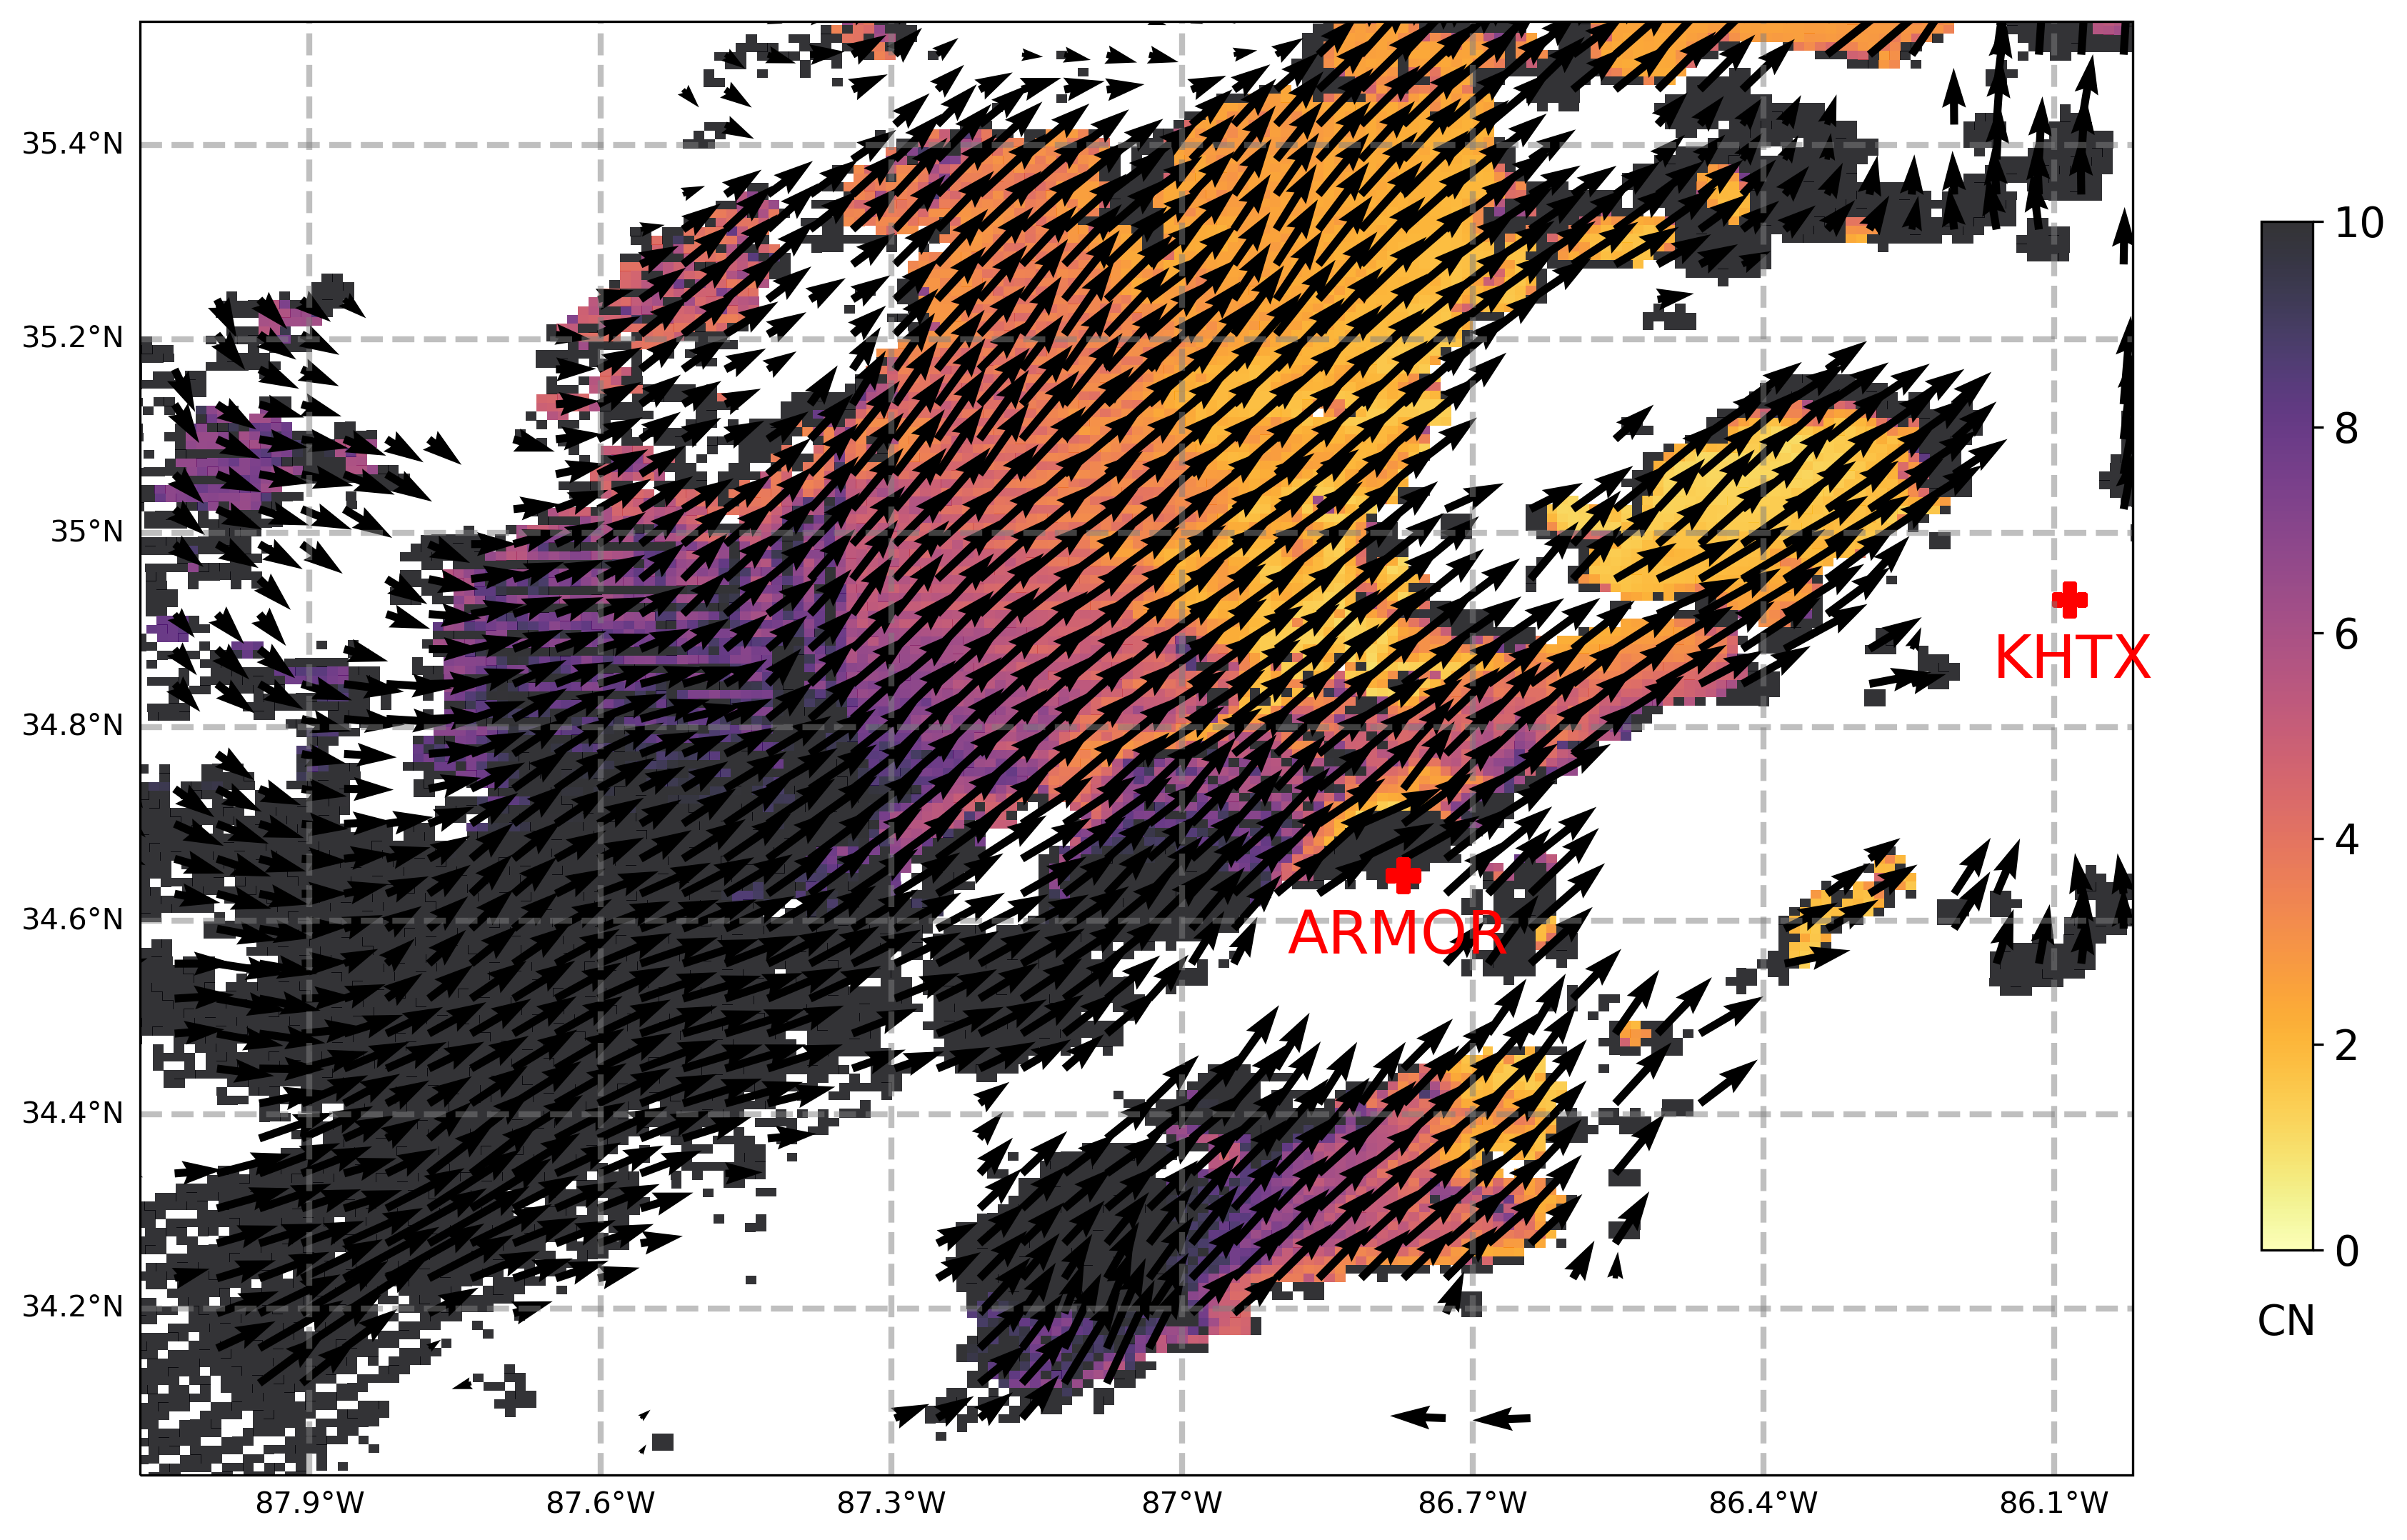

In [14]:
fig = plt.figure(figsize=(12,12),facecolor='white')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m', linewidth=1.)
plotting_var_CN = da_CN.sel(z0=plotting_alt_f).data
ext = 0.02
ax.set_extent([np.min(plotting_lon)+ext, np.max(plotting_lon)-ext,
               np.min(plotting_lat)+ext, np.max(plotting_lat)-ext], crs=ccrs.PlateCarree())
cf1 = ax.pcolormesh( plotting_lon, plotting_lat, plotting_var_CN
                    , cmap = 'inferno_r'
                    ,vmin=0,vmax=10
                    , alpha=0.8
                    , shading='auto'
                    , transform=ccrs.PlateCarree()
                    )
step = 4
cf_q = ax.quiver( plotting_lon_s[::step], plotting_lat_s[::step]
                    , plotting_var_u_s[::step, ::step], plotting_var_v_s[::step, ::step]
                    , scale=600
                    , width=0.004
                    , color='k'
                    , transform=ccrs.PlateCarree() 
                    )


ax.scatter(radar_lons, radar_lats, c='r', marker='P', s=120, transform=ccrs.PlateCarree())
ax.text(radar_lons[0]-0.12, radar_lats[0]-0.08, 'ARMOR', color='r', transform=ccrs.PlateCarree(), fontsize=20)
ax.text(radar_lons[1]-0.08, radar_lats[1]-0.08, 'KHTX', color='r', transform=ccrs.PlateCarree(), fontsize=20)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('CN', fontsize=14, y=-0.1)

Now, we can mask data where the condition number is greater than or equal to 10, leaving data with better geometry.

In [15]:
CN_threshold = 10
u_goodcondition = np.where(plotting_var_CN < CN_threshold, plotting_var_u_s, np.nan)
v_goodcondition = np.where(plotting_var_CN < CN_threshold, plotting_var_v_s, np.nan)


Text(0.5, -0.1, '[dBZ]')

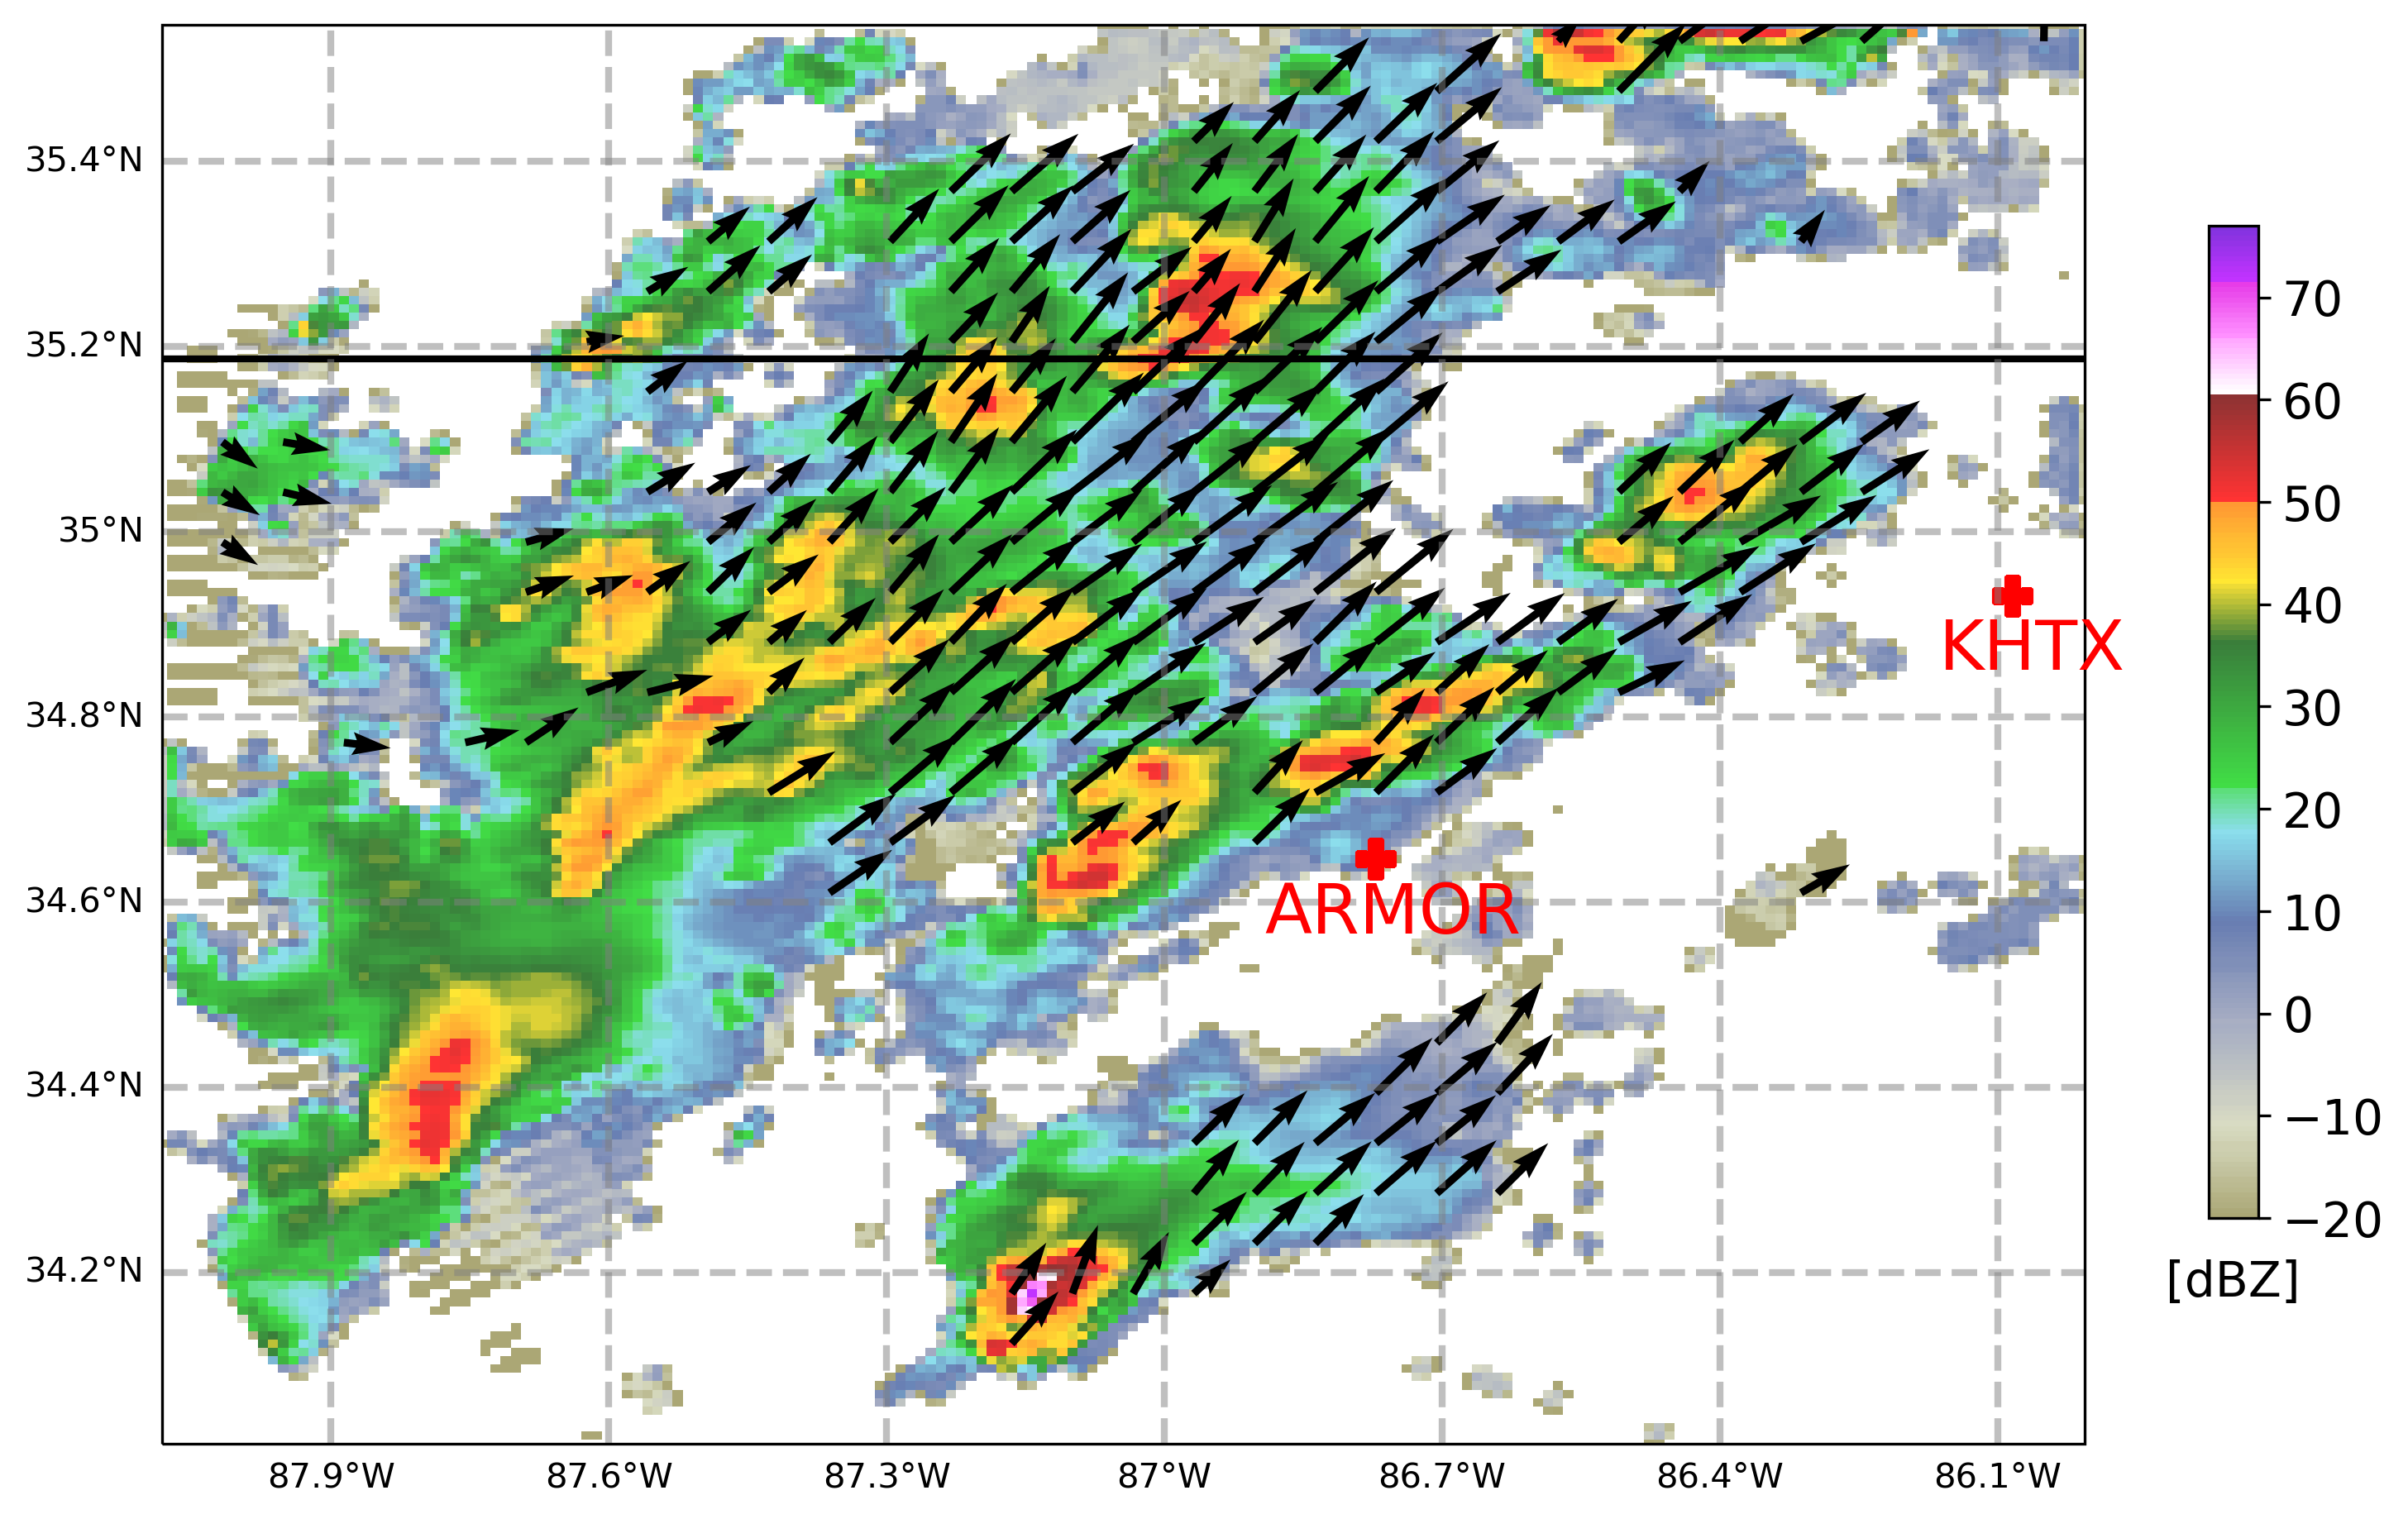

In [21]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
    
ext = 0.00    
ax.set_extent([np.min(plotting_lon_s)+ext, np.max(plotting_lon_s)-ext, np.min(plotting_lat_s)+ext, np.max(plotting_lat_s)-ext], crs=ccrs.PlateCarree())
    
cf1 = ax.pcolormesh( plotting_lon_s, plotting_lat_s, plotting_var_s
                    , cmap=ref_cmap, norm=ref_norm
                    , alpha=0.8
                    , shading='auto'
                    , transform=ccrs.PlateCarree() 
                    )
step = 6
cf_q = ax.quiver( plotting_lon_s[::step], plotting_lat_s[::step]
                    , u_goodcondition[::step, ::step], v_goodcondition[::step, ::step]
                    , scale=600
                    , width=0.004
                    , color='k'
                    , transform=ccrs.PlateCarree() 
                    )
ax.hlines(ds_radar_s.latitude[130],np.min(plotting_lon_s)+ext,np.max(plotting_lon_s)-ext, 
          'k',linewidth=2,transform=ccrs.PlateCarree())
ax.scatter(radar_lons, radar_lats, c='r', marker='P', s=120, transform=ccrs.PlateCarree())
ax.text(radar_lons[0]-0.12, radar_lats[0]-0.08, 'ARMOR', color='r', transform=ccrs.PlateCarree(), fontsize=20)
ax.text(radar_lons[1]-0.08, radar_lats[1]-0.08, 'KHTX', color='r', transform=ccrs.PlateCarree(), fontsize=20)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[dBZ]', fontsize=14, y=-0.1)


### 10. Plot cross sections of Divergence and Absolute Vorticity Fields

SAMURAI also outputs other kinematic fields, such as divergence and absolute vorticity fields. In this demonstration, we will show how to create a horizontal cross-section along the 35.2 latitude for the divergence and absolute vorticity fields in the following exercise

In [27]:
plotting_var_vort_s_cs = da_s_ABSVORT.sel(latitude=ds_radar_s.latitude[130])
plotting_var_CN_s_cs = da_CN[:,130,:]
plotting_var_u_s_cs = da_s_U.sel(latitude=ds_radar_s.latitude[130]).data
plotting_var_v_s_cs = da_s_V.sel(latitude=ds_radar_s.latitude[130]).data
plotting_var_w_s_cs = ds_radar_s['W'].sel(latitude=ds_radar_s.latitude[130]).data
plotting_var_div_s_cs = da_s_DIV.sel(latitude=ds_radar_s.latitude[130]).data
plotting_alt_s = ds_radar_s.altitude
u_cs_goodcondition = np.where(plotting_var_CN_s_cs < CN_threshold, plotting_var_u_s_cs, np.nan)
v_cs_goodcondition = np.where(plotting_var_CN_s_cs < CN_threshold, plotting_var_v_s_cs, np.nan)
w_cs_goodcondition = np.where(plotting_var_CN_s_cs < CN_threshold, plotting_var_w_s_cs, np.nan)
div_cs_goodcondition = np.where(plotting_var_CN_s_cs < CN_threshold, plotting_var_div_s_cs, np.nan)
vort_cs_goodcondition = np.where(plotting_var_CN_s_cs < CN_threshold, plotting_var_vort_s_cs, np.nan)

Text(0, 0.5, 'Altitude')

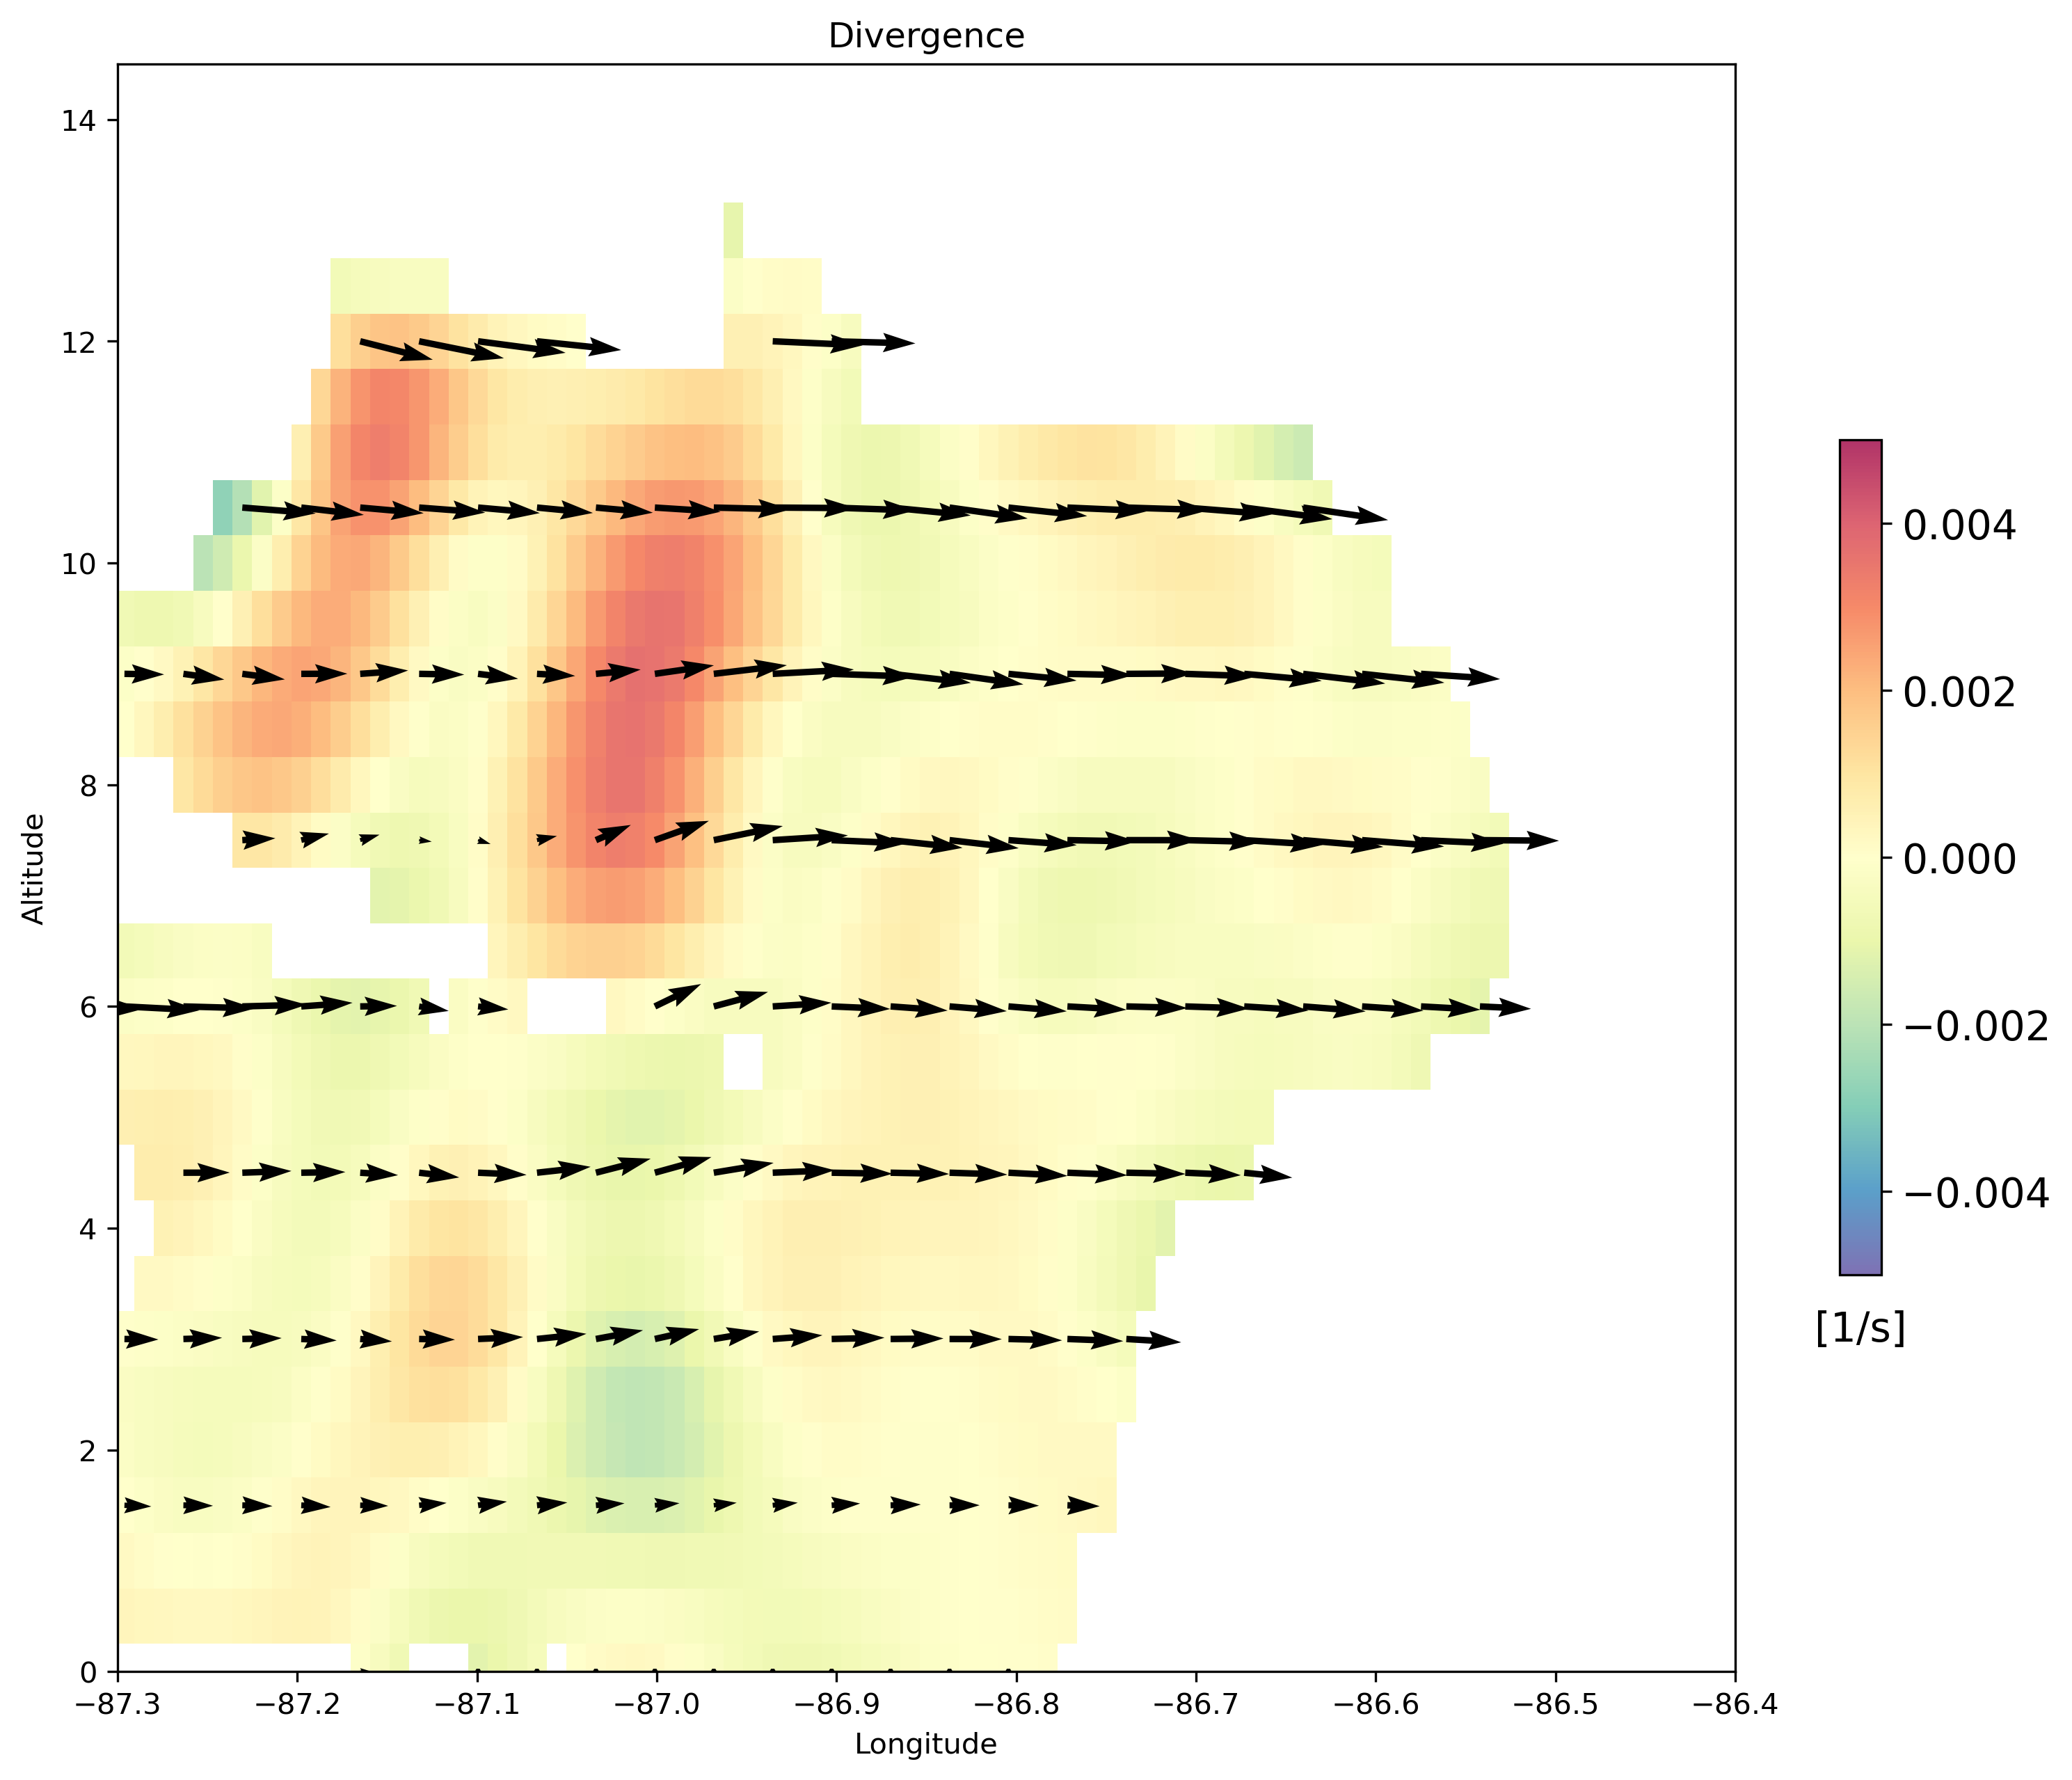

In [31]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
    
cf1 = ax.pcolormesh( plotting_lon_s, plotting_alt_s, div_cs_goodcondition/1e5
                    , cmap= 'Spectral_r'
                    , vmin=-0.005, vmax=0.005
                    , alpha=0.8
                    , shading='auto'
                   )
step = 3
cf_q = ax.quiver( plotting_lon_s[::step], plotting_alt_s[::step]
                    , u_cs_goodcondition[::step, ::step], w_cs_goodcondition[::step, ::step]
                    , scale=600
                    , width=0.004
                    , color='k'
                )
ax.set_title('Divergence')

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[1/s]', fontsize=14, y=-0.1)

ax.set_xlim([-87.3, -86.4])
ax.set_ylim([0, 14.5])
ax.set_xlabel("Longitude")
ax.set_ylabel("Altitude")

Text(0, 0.5, 'Altitude')

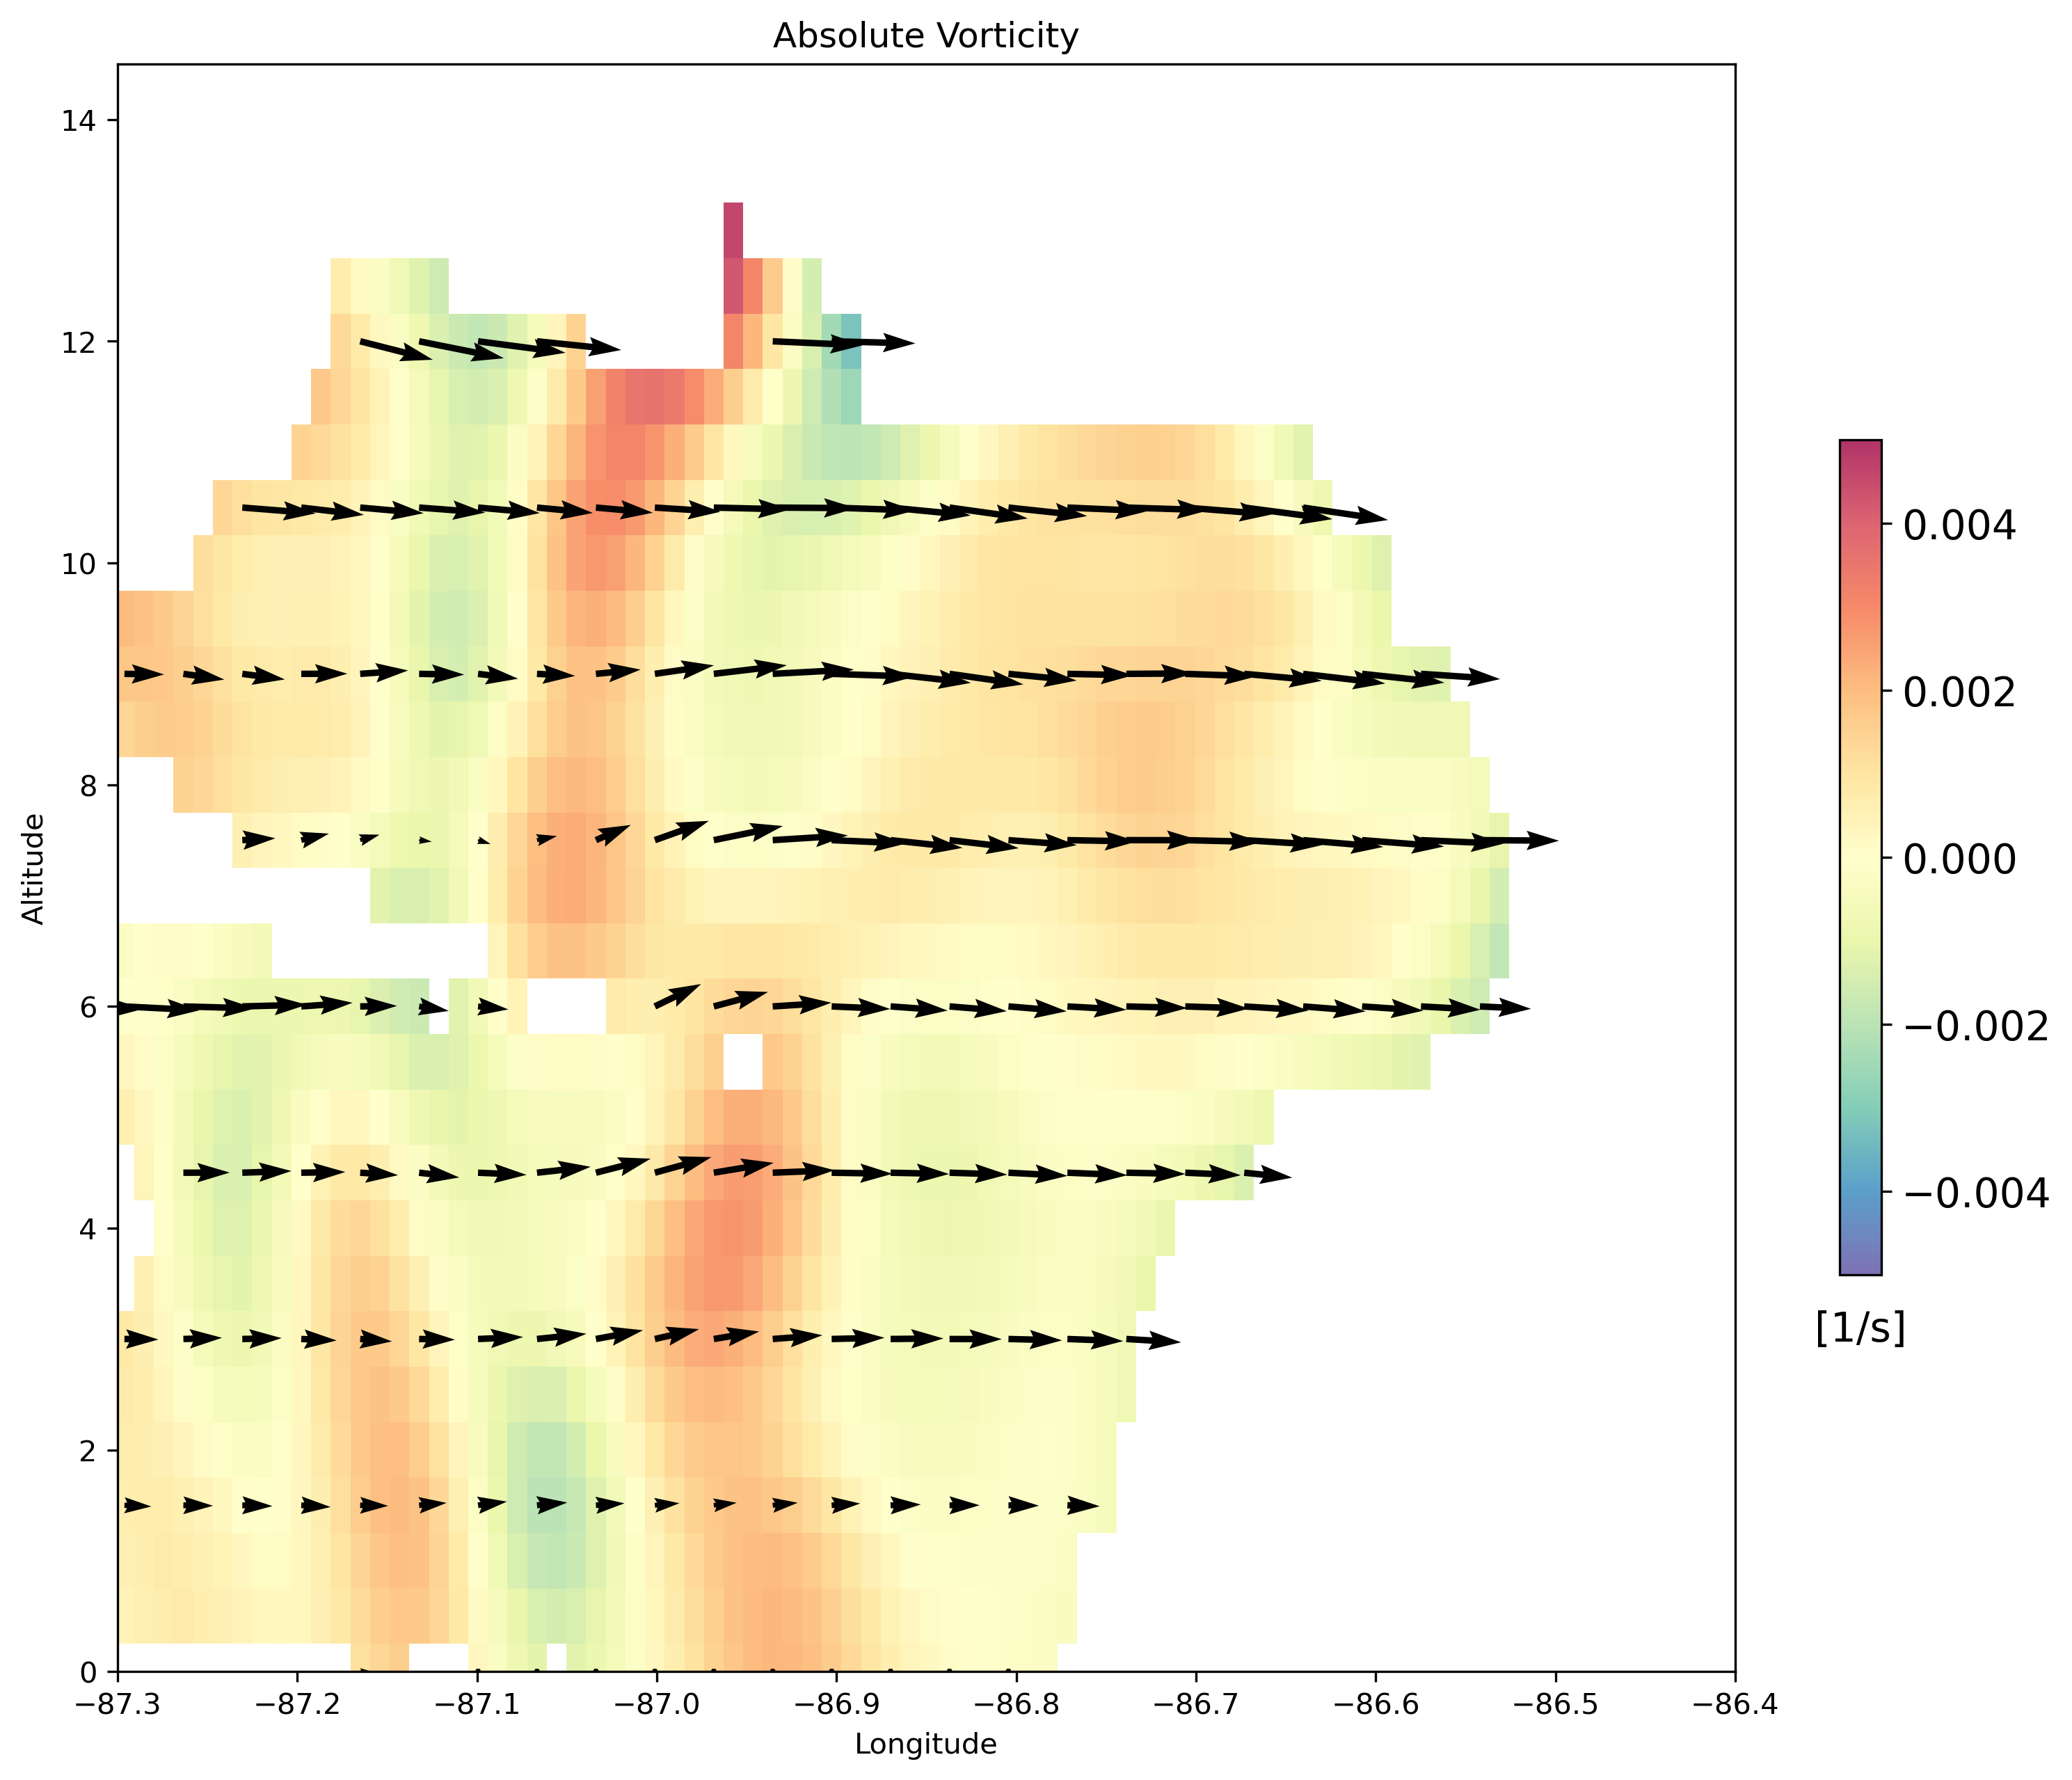

In [30]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
    
cf1 = ax.pcolormesh( plotting_lon_s, plotting_alt_s, vort_cs_goodcondition/1e5
                    , cmap= 'Spectral_r'
                    , vmin=-0.005, vmax=0.005
                    , alpha=0.8
                    , shading='auto'
                   )
step = 3
cf_q = ax.quiver( plotting_lon_s[::step], plotting_alt_s[::step]
                    , u_cs_goodcondition[::step, ::step], w_cs_goodcondition[::step, ::step]
                    , scale=600
                    , width=0.004
                    , color='k'
                )
ax.set_title('Absolute Vorticity')

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[1/s]', fontsize=14, y=-0.1)

ax.set_xlim([-87.3, -86.4])
ax.set_ylim([0, 14.5])
ax.set_xlabel("Longitude")
ax.set_ylabel("Altitude")

#### Congratulations! You have successfully completed the LROSE Wind tutorial!

### 11. An optional Exercise
There are other options to set in both FRACTL and SAMURAI, but the steps and parameters in this tutorial can produce a good quality wind field in many cases. Be critical with your own analysis and feel free to reach out to the LROSE team for questions as you analyze your own data.

For instance, if you change the **i_filter_length** [line 1546] and **j_filter_length** [line 1558] to 2, and also adjust the increments (**i_incr** and **j_incr**) in the i and j directions to 2, the resulting horizontal resolution scale remains similar to the current parameter setting of 4 km. However, the detailed structures exhibit slight differences.


<div>
<img src="./extras/LROSE_Extras.png" width="1000"/>
</div>